In [1]:
%matplotlib inline



import pandas as pd
import requests
import re
import ast
import numpy as np
import seaborn as sns

from collections import defaultdict


In [2]:
ccc_df = pd.read_csv("data/ccc_blm.csv")
ele_df = pd.read_csv("data/ele.csv")
cl_df = pd.read_csv("data/cl_blm.csv")
wiki_df = pd.read_csv("data/wiki_blm.csv")


dfs = [ccc_df, ele_df, cl_df, wiki_df]

In [3]:
df = pd.concat(dfs).reset_index(drop=True)
len(df)

5017

In [4]:
# fix stay commas

df['city_st'] = df['city_st'].str.replace(' , ', ', ')
df['city_st'] = df['city_st'].str.strip()


len(df)

5017

In [5]:
# eliminate non US events

countries = [
    "Finland",
    "England",
    "Wales",
    "Canada",
    "Scotland",
    "Germany",
    "Ireland", 'Sweden'
    "Netherlands",
    "New Zealand",
    "Denmark",
    "Australia",
    "Belgium",
    "France", 'Hungary',
]


def in_us(city_st):
    for c in countries:
        c2 = ", " + c
        if c2 in city_st:
            return False

    return True


df = df[df["city_st"].apply(in_us)].copy()
len(df)

4968

In [6]:
errors = {'Albuqeurque, NM' : 'Albuquerque, NM',
         'Bilings, MT' : 'Billings, MT',
         'Breckinridge, CO' : 'Breckinridge, CO',
          "Longbranch, NJ" : "Long Branch, NJ",
          'Lousiville, KY' : 'Louisville, KY',
          'Merrick, New York' : 'Merrick, NY',
          'Pittsfield Charter Township, MI' : 'Pittsfield, MI',
          'Pittsfield Township, MI' : 'Pittsfield, MI',
          'Phillipsburg, PA' : 'Philipsburg, PA',
          'South Sacramento, CA' :  'Sacramento, CA',
          'Shelbourne Falls, MA' : 'Shelburne Falls, MA',
          'Tallahasee, FL' : 'Tallahassee, FL',
          'Tampa Bay, FL' : "Tampa, Fl",
          'Voorhees Township, NJ' : 'Voorhees, NJ',
          'Warren Township, NJ' : 'Warren, NJ', 
          'Summerlin, NV' : 'Las Vegas, NV',
          'Stockton, TX' : 'Fort Stockton, TX',
          'Standford, CA' : 'Stanford, CA',
        
          
         }

for city in errors:
    df['city_st'] = df['city_st'].str.replace(city, errors[city])

In [7]:
#uniform saint to st
df['city_st'] = df['city_st'].str.replace('Saint ', 'St. ')

In [8]:
df['events'] = 1
df['size'] = df['size'].replace(0,np.nan)
df['size_imp'] = df['size'].fillna(11)


df = pd.concat([df, pd.get_dummies(df['collection'])], axis=1)

In [9]:
# extract urls to make them variables

def str_2_list(links):
    return ast.literal_eval(links)

df['url_list'] = df['urls'].apply(str_2_list)


urls = set([item for sublist in df['url_list'].values for item in sublist])

for url in urls:
    df[url] = df['urls'].str.contains(url)

/Users/nealcaren/opt/anaconda3/envs/tmwp/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


First Pass at Aggregation

In [10]:
# first sum by collection for multiple events by city
df_cd = df.groupby(['collection', 'date', 'city_st']).sum().reset_index()

In [11]:
df_cd['size_imp'] = df_cd['size'].fillna(11)



In [12]:
for v in ["CCC", 
    "Count Love", 
    "Elephrame",
         "Wikipedia"]:
    df_cd[v] = df_cd[v] > 0
    df_cd[v] = df_cd[v].astype(int)

In [13]:

aggregation = {
    "events": "max",
    "size": "max",
    "size_imp" : "max",
    "CCC" : "max",
    "Wikipedia" : "max",
    "Count Love" : "max",
    "Elephrame" : "max"
}


for url in urls:
    aggregation[url] = 'max'

df_cd = df_cd.groupby(["date", "city_st"]).agg(aggregation).reset_index()

In [14]:
# Create list of URLs

index_dict = defaultdict(list)

http_urls = [u for u in df_cd.keys() if 'http' in u]

for url in http_urls:
    for i in df_cd[df_cd[url] == True].index.values:
        index_dict[i].append(url)

url_df = pd.Series(index_dict).to_frame(name='urls')



In [15]:
keep = [
    "date",
    "city_st",
    "events",
    "size",
    "size_imp",
    "CCC",
    "Count Love",
    "Elephrame",
    "Wikipedia"

]

In [16]:
df_cd = df_cd[keep].merge(url_df, left_index=True, right_index=True)

In [17]:
df_cd['size'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [18]:
date_start = pd.to_datetime('2020-05-24')
df_cd = df_cd[pd.to_datetime(df_cd['date']) >= date_start].copy()



In [19]:
# remove future events
df_cd = df_cd[pd.to_datetime(df_cd['date']) < pd.Timestamp.today()].copy()
df_cd.reset_index(inplace=True)


In [20]:


df_cd.to_csv('../BLM-GFAABT.csv', index =False)




In [29]:
temp = df_cd.groupby(['date','city_st']).agg({'events': 'count',
                                            'Elephrame' : 'max',
                                            'CCC': 'max',
                                            'Count Love': 'max',
                                             'Wikipedia' : 'max'}).reset_index()

temp['cities'] = temp['events']
print(temp.groupby('date')[['cities','Elephrame','CCC','Count Love', 'Wikipedia']].sum().to_markdown())

| date       |   cities |   Elephrame |   CCC |   Count Love |   Wikipedia |
|:-----------|---------:|------------:|------:|-------------:|------------:|
| 2020-05-25 |        1 |           0 |     0 |            0 |           1 |
| 2020-05-26 |        9 |           3 |     4 |            7 |           0 |
| 2020-05-27 |       14 |           6 |     8 |           11 |           0 |
| 2020-05-28 |       57 |          10 |    33 |           40 |          13 |
| 2020-05-29 |      181 |          33 |    92 |          121 |          45 |
| 2020-05-30 |      507 |          69 |   146 |          304 |         174 |
| 2020-05-31 |      550 |          85 |   169 |          306 |         163 |
| 2020-06-01 |      342 |          36 |   131 |          141 |         103 |
| 2020-06-02 |      293 |          35 |   144 |           93 |          64 |
| 2020-06-03 |      252 |          64 |    97 |           69 |          59 |
| 2020-06-04 |      181 |          30 |    35 |           80 |          49 |

In [22]:
print(df_cd.groupby('date')['events'].sum().to_markdown())

| date       |   events |
|:-----------|---------:|
| 2020-05-25 |        1 |
| 2020-05-26 |       10 |
| 2020-05-27 |       16 |
| 2020-05-28 |       67 |
| 2020-05-29 |      200 |
| 2020-05-30 |      555 |
| 2020-05-31 |      572 |
| 2020-06-01 |      362 |
| 2020-06-02 |      320 |
| 2020-06-03 |      276 |
| 2020-06-04 |      191 |
| 2020-06-05 |      220 |
| 2020-06-06 |      263 |
| 2020-06-07 |      195 |
| 2020-06-08 |       69 |
| 2020-06-09 |       44 |
| 2020-06-10 |       18 |


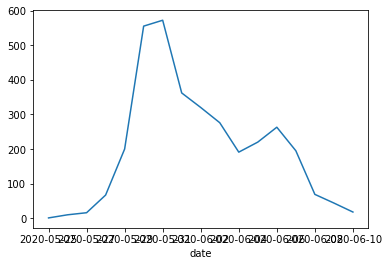

In [23]:
df_cd.groupby('date')['events'].sum().plot();

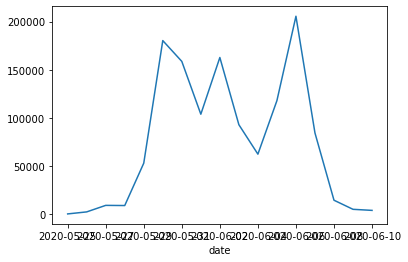

In [24]:
df_cd.groupby('date')['size_imp'].sum().plot();

In [25]:
df_cd['size_imp'].count()

3065

In [26]:
df_cd['size_imp'].sum()

1265451.0

In [27]:


df_cd['size'].describe()

count     1877.000000
mean       667.225892
std       3253.988552
min          1.000000
25%        100.000000
50%        200.000000
75%        350.000000
max      95500.000000
Name: size, dtype: float64

In [28]:
df_cd.groupby(["CCC", "Count Love", 'Elephrame'])['events'].count().reset_index()

,CCC,Count Love,Elephrame,events
0,0,0,0,774
1,0,0,1,255
2,0,1,0,875
3,0,1,1,112
4,1,0,0,528
5,1,0,1,51
6,1,1,0,325
7,1,1,1,145
